In [1]:
import tensorflow as tf
from tensorflow import keras
from tqdm.keras import TqdmCallback
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def poiseuille(R=1,dpdx=-0.01,nu=0.01,Nr=100,figure=True):
  
    r = np.linspace(-R,R,Nr)
    u = -1/4/nu *dpdx*(R**2-r**2)
    if figure:
        fig, ax = plt.subplots(figsize=(10,4))
        ax.scatter(r,u)
        ax.set_ylabel("u [m/s]")
        ax.set_xlabel("r [m]")
    umax = -1/4/nu*dpdx*R*R
    Re = umax*2*R/nu
    return Re,r,u

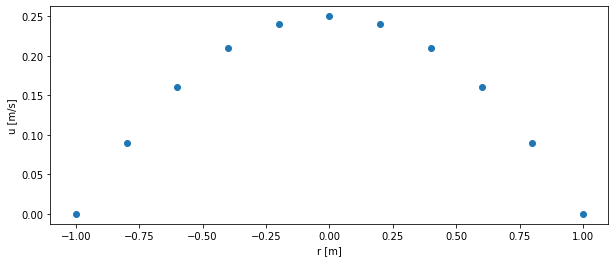

In [3]:
Re, r, u = poiseuille(R=1,dpdx=-0.01,nu=0.01,Nr=11,figure=True)

In [4]:
Re

50.0

In [44]:
# making the samples
rey   = []
perf  = []
rp    = []
for Reynolds in np.linspace(-0.99,0.99,1000):
    re, r, u = poiseuille(R=Reynolds,dpdx=-0.01,nu=0.01,Nr=11,figure=False)
    rey.append([re])
    perf.append(u)
    rp.append(r)
# lists to array and scale
reynolds_array = np.array(rey)
reynolds_scale = reynolds_array/reynolds_array.max()
profile_array  = np.array(perf)
profile_scale  = profile_array/profile_array.max()
# split test and train arrays with np.split
reynolds_train, reynolds_test = np.split(reynolds_scale, 2)
profile_train, profile_test   = np.split(profile_scale, 2)
# splitting with slicing
reynolds_train_s = reynolds_scale[0:499:1]
reynolds_test_s  = reynolds_scale[500:999:1]
profile_train_s  = profile_scale[0:499:1]
profile_test_s   = profile_scale[500:999:1]

In [13]:
np.shape(reynolds_scale)

(1000, 1)

In [14]:
np.shape(profile_scale)

(1000, 11)

In [56]:
# creating layers
inputs = tf.keras.Input(shape=1, name='input')
hidden = tf.keras.layers.Dense(20, activation='relu', name='hidden_1')(inputs)
output = tf.keras.layers.Dense(11, name='output')(hidden)
# creating the model
model  = keras.Model(inputs, output, name='model')
# printing
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 hidden_1 (Dense)            (None, 20)                40        
                                                                 
 output (Dense)              (None, 11)                231       
                                                                 
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [57]:
# compiling the model
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss      = tf.keras.losses.MeanSquaredError()
model.compile(optimizer, loss, metrics=['mae'])
fitting = model.fit(reynolds_train_s, profile_train_s, epochs=160, verbose=0, 
                    callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

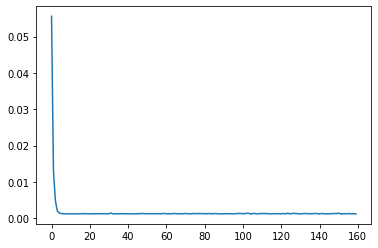

In [58]:
plt.plot(fitting.history['loss'])

In [59]:
# test the model with the originla Reynolds, Re=50.0
test = model.predict([reynolds_test_s])

16/16 [==============================] - 0s 2ms/step


In [60]:
np.shape(test)

(499, 11)

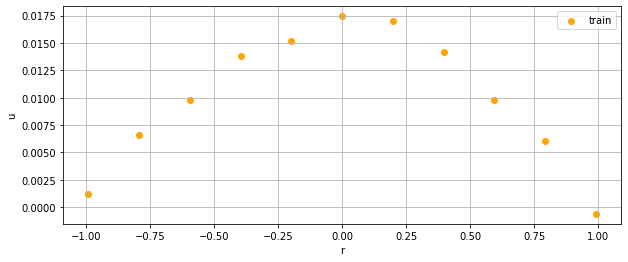

In [64]:
# plot
fig, ax = plt.subplots(figsize=(10,4))

#ax.plot(r,u, label='orginal')
ax.scatter(r,test[100]*profile_array.max(), label='train', color='orange')

ax.set_xlabel('r')
ax.set_ylabel('u')
ax.legend()
ax.grid()